### Predicting the total number of bikes rented in a given hour in Washington, D.C
RF vs Neural Net
data: http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [232]:
import pandas as pd
import tensorflow as tf

import keras

# from tensorflow import keras
from keras import layers

print(tf.__version__)

1.5.0


In [187]:
bike_rentals = pd.read_csv("hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### The distribution of total rentals

(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

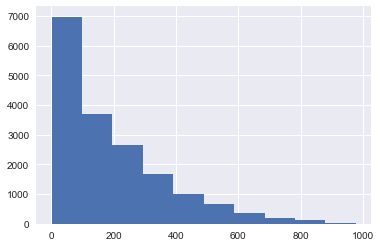

In [188]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.hist(bike_rentals["cnt"])

The correlation of each column with cnt

In [189]:
cnt_corr = bike_rentals.corr()["cnt"].abs().sort_values(ascending=False)
cnt_corr

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

In [190]:
strong_corr = cnt_corr[cnt_corr >= .3]

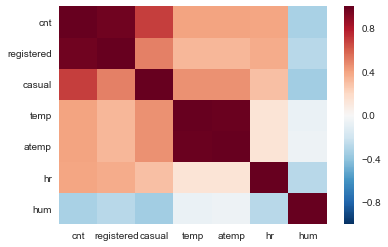

In [192]:
import seaborn as sns

sns.heatmap(bike_rentals[strong_corr.index].corr())

Bundling similar times together to enable the model to make better decisions

In [193]:
def assign_label(hours):
    if hours >= 0 and hours < 6:
        return 4
    if hours >= 6 and hours < 12:
        return 1
    if hours >= 12 and hours < 18:
        return 2
    if hours >= 18 and hours <= 24:
        return 3

bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

### Error metric - MSE
MSE works on continuous numeric data, which fits our data quite well

### Regression

In [194]:
from sklearn.metrics import mean_squared_error


# 80% of the rows in bike_rentals to be part of the training set
train = bike_rentals.sample(frac=.8)
# False when a row in bike_rentals isn't found in train
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

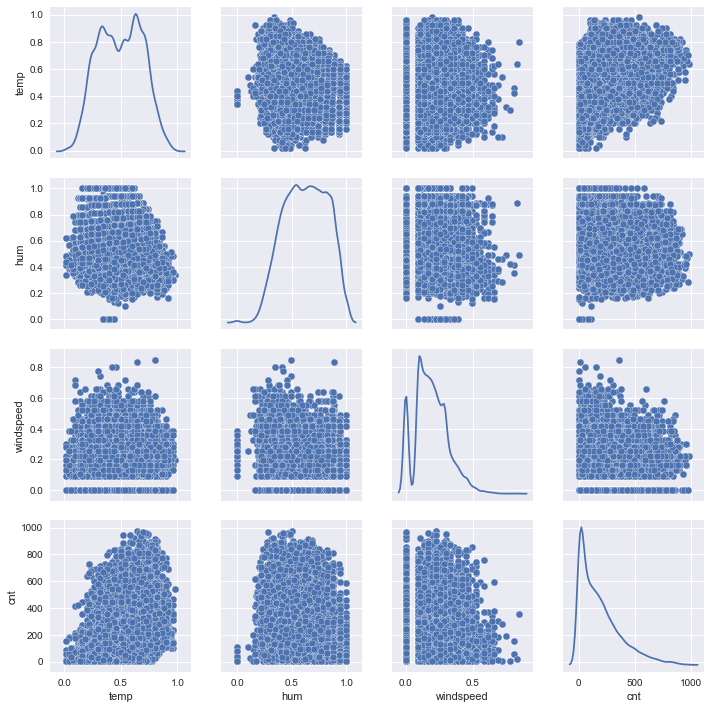

In [195]:
sns.pairplot(train[["temp","hum", "windspeed", "cnt"]], diag_kind="kde")

In [220]:
from sklearn.linear_model import LinearRegression

predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")
predictors.remove("temp")

In [230]:
lr = LinearRegression()
lr.fit(train[predictors], train["cnt"])
lr_predictions = lr.predict(test[predictors])

In [231]:
mean_squared_error(test["cnt"], lr_predictions)

17594.411779440376

The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

### Decision Tree

In [199]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(train[predictors], train["cnt"])
dt_predictions = dt.predict(test[predictors])

In [200]:
mean_squared_error(test["cnt"], dt_predictions)

3193.275604142693

By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

### Randon Forest

In [201]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(min_samples_leaf=5)
rf.fit(train[predictors], train["cnt"])
rf_predictions = rf.predict(test[predictors])

In [202]:
mean_squared_error(test["cnt"],rf_predictions)

1874.967845342438

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy

In [223]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train[predictors].keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

    optimizer = keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [224]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [227]:
example_batch = train[predictors][:10]
example_result = model.predict(example_batch)
example_result

array([[ -641.14276 ],
       [-1304.9346  ],
       [-1471.2251  ],
       [  -21.654345],
       [-1083.6184  ],
       [ -415.51178 ],
       [-1467.758   ],
       [-1486.0538  ],
       [ -820.77295 ],
       [  -60.005646]], dtype=float32)

In [255]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
  train[predictors], train["cnt"],
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [256]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
495,9205.426152,63.433770,9205.426152,16908.860316,84.794444,16908.860316,495
496,8790.827857,62.354970,8790.827857,7316.907237,58.856420,7316.907237,496
497,9084.067980,63.481428,9084.067980,9198.781267,61.820020,9198.781267,497
498,9231.335292,63.778221,9231.335292,9507.117118,66.638958,9507.117118,498
499,9295.762668,63.723205,9295.762668,18284.006363,86.075140,18284.006363,499


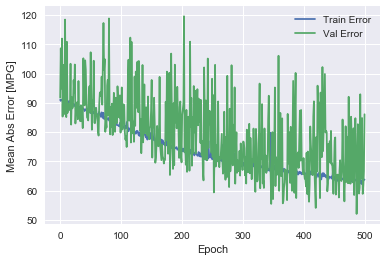

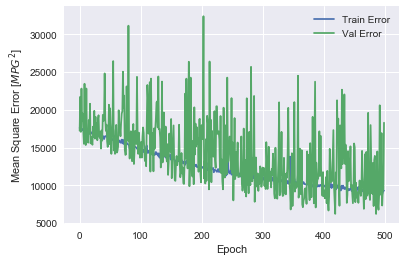

In [257]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#     plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#     plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)

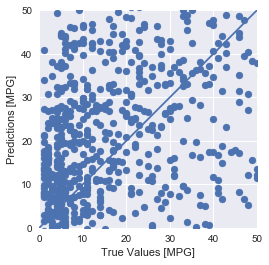

In [258]:
nn_predictions = model.predict(test[predictors]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test['cnt'], nn_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [259]:
mean_squared_error(test["cnt"], nn_predictions)

17160.7224052929